In [1]:
import os
import keras
import logging
import numpy as np
from imageio import imread
from keras.models import Model
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.optimizers import Adam
from PIL import Image, ImageFilter
from keras.models import Sequential
from keras.engine.topology import Layer
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate

%matplotlib inline
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

Using TensorFlow backend.


### Dataset managment

In [2]:
def download_ds(download_address, save_address):
    if os.path.exists(save_address):
        logger.info("The dataset has already been downloaded.")
    else:
        !wget -O ds.zip {download_address}
        !unzip ds.zip
        !mv ShapesData_few-show-learning {save_address}
        !find {save_address} -name '*.DS_Store' -delete

In [3]:
class DS:
    def __init__(self):
        self.x_tr = None
        self.y_tr = None
        self.labels_tr = None
        self.x_val = None
        self.Y_val = None
        self.labels_val = None
        self.X_eval = None
        self.Y_eval = None
        self.labels_eval = None
        self.names_tr = []
        self.names_val = []
        self.names_eval = []
        #self.labels_dict = None

    def __Load_data(self,address, new_im_size, train_ratio):
        class_count = len(os.listdir(address))
        train_count = int(class_count*train_ratio)
        train_idx = np.random.choice(class_count, size = train_count, replace = False)
        x_tr, y_tr, x_val, y_val, names_tr, names_val = [],[],[],[], [], []
        #labels_idx = dict()
        labels_tr = []
        labels_val = []
        offset_tr, offset_val = 0,0
        if os.path.exists(os.path.join(address,".DS_Store")):
            os.remove(os.path.join(address, ".DS_Store"))
        for i , label in enumerate(os.listdir(address)):
            labels_address = os.path.join(address, label)
            x, y, labels, names = (x_tr, y_tr, labels_tr, names_tr) if i in train_idx else (x_val, y_val, labels_val, names_val)
            #labels_idx[i] = label
            for image_name in os.listdir(labels_address):
                image_address = os.path.join(labels_address, image_name)
                try:
                    img = Image.open(image_address).convert('RGB')
                    img = img.resize((new_im_size, new_im_size))
                    x.append(np.array(img, dtype=np.float32))
                    y.append(i)
                except:
                    logger.info("ERROR: can't load {}".format(image_address))
            label_count = len(os.listdir(labels_address))
            names.append(label)
            if i in train_idx:
                labels.append((i, label_count , offset_tr))
                offset_tr+=label_count
            else:
                labels.append((i, label_count , offset_val))
                offset_val+=label_count

        x_tr = np.array(x_tr)
        y_tr = np.array(y_tr)
                
        x_val = np.array(x_val)
        y_val = np.array(y_val)

        if class_count-train_count > 0:
            x_val = np.array(x_val)
            y_val = np.array(y_val)

        return x_tr, y_tr, np.array(labels_tr), names_tr, x_val, y_val, np.array(labels_val), names_val

    def Load_evaluation(self, address, new_im_size):
        self.x_eval, self.eval, self.labels_eval,self.names_eval, _, _, _, _ =self.__Load_data(address, new_im_size, 1)

    def Load_background(self,address, new_im_size, train_ratio):
        self.x_tr, self.y_tr, self.labels_tr,self.names_tr, self.x_val, self.y_val, self.labels_val, self.names_val=self.__Load_data(address, new_im_size, train_ratio)
    
    def get_paired_data(self,batch_size, x, labels):
        half_size = batch_size // 2
        class_count = labels.shape[0]
        rnd_classes = np.random.choice(class_count, size = half_size, replace = True)
        rnd_pos_classes_lbl =labels[rnd_classes]
        rnd_1 = (np.random.uniform(0,1, half_size)*rnd_pos_classes_lbl[:,1]+rnd_pos_classes_lbl[:,2]).astype(np.int32)
        rnd_pos_2 = (np.random.uniform(0,1, half_size)*rnd_pos_classes_lbl[:,1] +rnd_pos_classes_lbl[:,2]).astype(np.int32)

        rnd_neg_2_classes =  (rnd_classes + np.random.randint(1,class_count-1,half_size)) % class_count
        rnd_neg_classes_lbl =labels[rnd_neg_2_classes]
        rnd_neg_2 = (np.random.uniform(0,1, half_size)*rnd_neg_classes_lbl[:,1]+rnd_neg_classes_lbl[:,2]).astype(np.int32)

        pair_1 = x[np.repeat(rnd_1,2)]
        pair_2 = np.concatenate((x[rnd_pos_2], x[rnd_neg_2]))
        y = np.ones(half_size*2)
        y[half_size:]= 0
        return [pair_1, pair_2], y

    def get_paired_train(self, batch_size):
        while True:
            yield self.get_paired_data(batch_size, self.x_tr, self.labels_tr)

    def get_paired_val(self, batch_size):
        while True:
            return self.get_paired_data(batch_size, self.x_val, self.labels_val)
    
    def get_paired_one_shot_eval(self,x, labels, class_idx):
        class_count = labels.shape[0]
        class_spec = labels[class_idx]
        pair_1 = np.zeros((class_count, x.shape[1], x.shape[2], x.shape[3]))
        pair_2 = np.zeros((class_count, x.shape[1], x.shape[2], x.shape[3]))
        rnd1 = (np.random.uniform(0,1, 1)*class_spec[1]+class_spec[2]).astype(np.int32)
        rnd1_repeated = np.repeat(rnd1, class_count)
        pair_1[:,:,:,:] = x[rnd1_repeated]
        classes = np.arange(class_count)
        rnd2 = (np.random.uniform(0,1, class_count)*labels[:,1]+labels[:,2]).astype(np.int32)
        pair_2[:,:,:,:] = x[rnd2]
        
        y = np.zeros(class_count)
        y[class_idx] = 1
        return [pair_1, pair_2], y  
        
    def normalize(self):
        self.x_tr= self.x_tr /255
        self.x_val= self.x_val / 255
        self.x_eval= self.x_eval / 255

    def standardize_images(self,x):
        if x is None:
            return None
        means = np.mean(x, axis=0)
        stds = np.std(x, axis=0)
        return (x-means)/stds

    def standardize_ds(self):
        self.x_tr = self.standardize_images(self.x_tr)
        self.x_val = self.standardize_images(self.x_val)
        self.x_eval = self.standardize_images(self.x_eval)
    



### Model

In [4]:
def siamese(input_shape):
    init_b = keras.initializers.RandomNormal(mean = 0.5, stddev=0.01)
    init_w = keras.initializers.RandomNormal(mean = 0.0, stddev=0.01)
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,kernel_initializer=init_w, bias_initializer=init_b, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu', kernel_initializer=init_w, bias_initializer=init_b, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=init_w, bias_initializer=init_b, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=init_w, bias_initializer=init_b, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',kernel_regularizer=l2(1e-3), kernel_initializer=init_w,bias_initializer=init_b))
    dense_layer = Dense(1,activation='sigmoid',bias_initializer=init_b)
    L1_layer = Lambda(lambda tensors:keras.backend.abs(tensors[0] - tensors[1]))
    input_1, input_2 = Input(input_shape), Input(input_shape)
    outputs = dense_layer(L1_layer([model(input_1), model(input_2)]))
    siamese_model = Model(inputs=[input_1,input_2],outputs=outputs)
    return siamese_model


In [5]:
'''
print(batch1_ds.labels)
print(batch1_ds.x_tr.shape)
print(batch1_ds.y_tr.shape)
print(batch1_ds.labels_tr)
print(batch1_ds.x_val.shape)
print(batch1_ds.y_val.shape)
print(batch1_ds.labels_val)
'''

'\nprint(batch1_ds.labels)\nprint(batch1_ds.x_tr.shape)\nprint(batch1_ds.y_tr.shape)\nprint(batch1_ds.labels_tr)\nprint(batch1_ds.x_val.shape)\nprint(batch1_ds.y_val.shape)\nprint(batch1_ds.labels_val)\n'

In [6]:
def eval_siamese(model,ds, count):
    class_count = ds.labels_eval.shape[0]
    corrects = np.zeros(class_count)
    per_class = np.zeros(class_count)
    for i in range(count):
        pairs, y = ds.get_paired_one_shot_eval(ds.x_eval, ds.labels_eval, i%class_count)
        predictions = model.predict(pairs)
        corrects[i%class_count] += np.argmax(predictions) == np.argmax(y)
        per_class[i%class_count] += 1
    acc = corrects/per_class
    return acc, np.average(acc)

In [7]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Batch1

Download and load

In [8]:
bg_download_address = "https://www.dropbox.com/s/9imgl9m0qzin55g/ShapesData_few-show-learning.zip?dl=0"
bg_save_address = "dataset"
eval_download_address = "https://www.dropbox.com/s/bhk86noqwollrs9/new_data.zip?dl=1"
eval_save_address = "new_data"
new_im_size = 105
download_ds(bg_download_address, bg_save_address)
download_ds(eval_download_address, eval_save_address)
batch1_address = os.path.join(bg_save_address, "batch1")
batch1_ds = DS()
batch1_ds.Load_background(batch1_address, 105, 0.7)
batch1_ds.Load_evaluation(os.path.join(eval_save_address, 'artificiale/camera'), 105)
#batch1_ds.normalize()
#batch1_ds.standardize_ds()

### Creating the model

In [9]:
model = siamese((new_im_size, new_im_size, 3))
model.summary()
optimizer = Adam(lr = 0.00006)

model.compile(loss="binary_crossentropy",optimizer=optimizer)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         38960448    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]         

Train

In [10]:
batch_size = 20
cb = [EarlyStopping(min_delta=0.0005, patience=150)]
history =model.fit_generator(generator=batch1_ds.get_paired_train(batch_size),steps_per_epoch=1, epochs = 2000,\
                    validation_data = batch1_ds.get_paired_val(batch_size), validation_steps = 10, callbacks= cb)

Epoch 1/2000
1/1 [==============================] - 2s 2s/step - loss: 4.5240 - val_loss: 4.5119
Epoch 2/2000
1/1 [==============================] - 0s 214ms/step - loss: 4.4979 - val_loss: 4.4940
Epoch 3/2000
1/1 [==============================] - 0s 213ms/step - loss: 4.4758 - val_loss: 4.4743
Epoch 4/2000
1/1 [==============================] - 0s 212ms/step - loss: 4.4595 - val_loss: 4.4588
Epoch 5/2000
1/1 [==============================] - 0s 214ms/step - loss: 4.4769 - val_loss: 4.4475
Epoch 6/2000
1/1 [==============================] - 0s 211ms/step - loss: 4.4690 - val_loss: 4.4323
Epoch 7/2000
1/1 [==============================] - 0s 215ms/step - loss: 4.3995 - val_loss: 4.4194
Epoch 8/2000
1/1 [==============================] - 0s 215ms/step - loss: 4.4167 - val_loss: 4.4104
Epoch 9/2000
1/1 [==============================] - 0s 210ms/step - loss: 4.4418 - val_loss: 4.3937
Epoch 10/2000
1/1 [==============================] - 0s 210ms/step - loss: 4.4129 - val_loss: 4.3826
Ep

Evaluation

In [11]:
#paired_val, y = batch1_ds.get_paired_val(200)
accs, avg_acc = eval_siamese(model,batch1_ds, 1000)

for i, label in enumerate(batch1_ds.names_eval):
    print("the accuracy for {}: {}".format(label, accs[i]))

the accuracy for tree: 0.98
the accuracy for if: 0.95
the accuracy for crocodile: 0.7
the accuracy for lion: 0.86
the accuracy for girl: 0.82
the accuracy for monkey: 0.87
the accuracy for house: 0.83
the accuracy for boy: 0.76
the accuracy for car: 0.83
the accuracy for bat: 0.62


In [12]:
batch1_ds.x_eval.shape

(207, 105, 105, 3)

In [13]:
history.history.keys()

dict_keys(['val_loss', 'loss'])

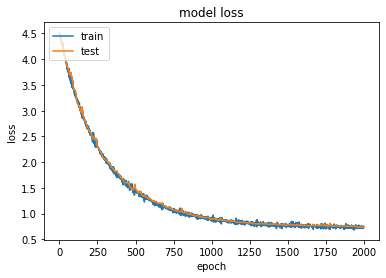

In [14]:
plot_history(history)